In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pathlib 
import os
import pickle
import torch

import PT_files.save_load as sl
from PT_files.afterburner_torch import afterburner
from PT_files.model import DnCNN_B
from DnCNN_NP.layers_np import relu, np_BatchNorm2d, np_Conv2d
from DnCNN_NP.model_np import np_DnCNN
from DnCNN_NP.np_afterburner import full_img_pass

import time 
import pdb

Using cuda device


In [2]:
# Loading data & weights dictionary

PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

# samp = sample[0][0][1000:3000, 1000:3000]
# samp = samp.reshape((1, 1, 2000, 2000))
samp = sample[0][0]

Shape of test set= (108, 1, 6000, 6000)


Changle `afterburner` to run on single example (ie. for use on FVC image per day) as well as get rid of the `print` output it gives when ran

In [3]:
denoised_2k = afterburner(dataset=test_data, model=DnCNN_B,  model_params='2k_model_bs64_e800_ps50_Adam.pth', samp_idx=0) 

In [ ]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    x_start_idx,
                    y_start_idx):
    
    # This commented code is used to create a box on the full FVC image
    # of the sub-image of interest.
    
#    rect = Rectangle((x_start_idx, y_start_idx), size, size, linewidth=2, edgecolor='r', facecolor='none')
#     ax[0].add_patch(rect)
    
    data_6k_raw = raw_data[0][0][0][y_start_idx:y_start_idx+size, x_start_idx:x_start_idx+size]
    data_6k_truth = raw_data[1][0][0][y_start_idx:y_start_idx+size, x_start_idx:x_start_idx+size]

    full_img_inf = inf_data[0][0][y_start_idx:y_start_idx+size, x_start_idx:x_start_idx+size]
        
    
    fig, ax = plt.subplots(3, 3,figsize=(26, 22))
    
    # For 200x200 patches
    vmin, vmax = np.percentile(data_6k_raw, (1,99))
    # For full image
    vmin_full, vmax_full = np.percentile(raw_data[0][0][0], (1,99))
    # For residuals
    vmin_resid, vmax_resid = np.percentile((full_img_inf - data_6k_raw), (1,99))

    # Comparing noise vs. truth
    ax[0,0].imshow(data_6k_truth, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0,0].axis('off')
    ax[0,0].set_title('Truth',fontsize=28) 
    ax[0,1].imshow(data_6k_raw, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0,1].axis('off')
    ax[0,1].set_title('Noise',fontsize=28) 
    ax[0,2].imshow(data_6k_truth - data_6k_raw, vmin=vmin_resid, vmax=vmax_resid, cmap='bwr', origin='upper', interpolation='none')
    ax[0,2].axis('off')
    ax[0,2].set_title('Truth-Noise Residual', fontsize=28)
  
    
    # Comparing Noise vs. Denoised
    ax[1,0].imshow(full_img_inf, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1,0].axis('off')
    ax[1,0].set_title('Denoised',fontsize=28)
    ax[1,1].imshow(data_6k_raw, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1,1].axis('off')
    ax[1,1].set_title('Noise',fontsize=28) 
    ax[1,2].imshow(full_img_inf - data_6k_raw, vmin=vmin_resid, vmax=vmax_resid, cmap='bwr', origin='upper', interpolation='none')
    ax[1,2].axis('off')
    ax[1,2].set_title('Denoised-Noise Residual', fontsize=28)
  
       
       
    # Comparing Denoised vs. Truth
    ax[2,0].imshow(data_6k_truth, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[2,0].axis('off')
    ax[2,0].set_title('Truth',fontsize=28) 
    ax[2,1].imshow(full_img_inf, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[2,1].axis('off')
    ax[2,1].set_title('Denoised',fontsize=28) 
    ax[2,2].imshow(data_6k_truth - full_img_inf, vmin=vmin_resid, vmax=vmax_resid, cmap='bwr', origin='upper', interpolation='none')
    ax[2,2].axis('off')
    ax[2,2].set_title('Truth-Denoised Residual', fontsize=28)
   
    

    fig.tight_layout()

plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                x_start_idx=4900,
                y_start_idx=3600)

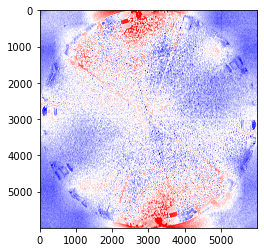

In [13]:
residual = test_data[1][0] - denoised_2k

vmin_resid, vmax_resid = np.percentile(residual, (1,99))


plt.imshow(residual[0][0], vmin=vmin_resid, vmax=vmax_resid, origin='upper', cmap='bwr')

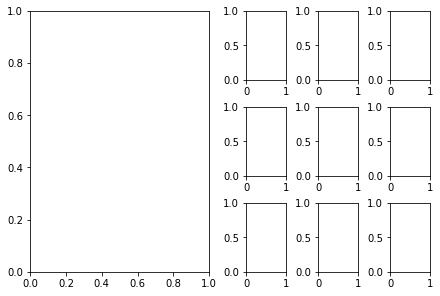

In [ ]:
fig10 = plt.figure(constrained_layout=True)
gs0 = fig10.add_gridspec(1, 2)

gs00 = gs0[0].subgridspec(1,1)
fig10.add_subplot(gs00[0, 0])

gs01 = gs0[1].subgridspec(3, 3)
# gs01 = gs0[1].subgridspec(3, 3)

for a in range(3):
    for b in range(3):
        fig10.add_subplot(gs01[a, b])
        # fig10.add_subplot(gs01[b, a])

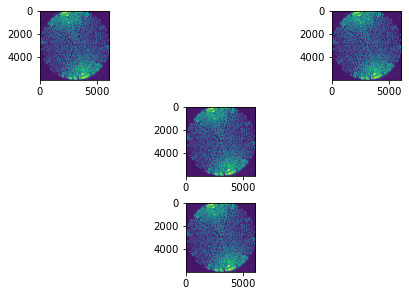

In [28]:
# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.imshow(denoised_2k[0][0])

axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    A.C
    BBB
    .D.
    """
)
identify_axes(axd)

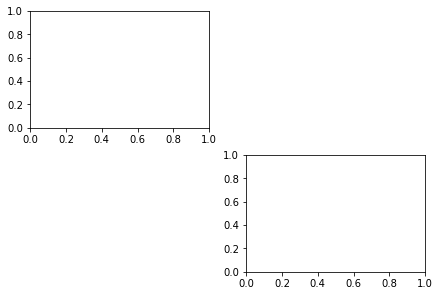

In [20]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    aX
    Xb
    """,
    empty_sentinel="X",
)
# identify_axes(axd)

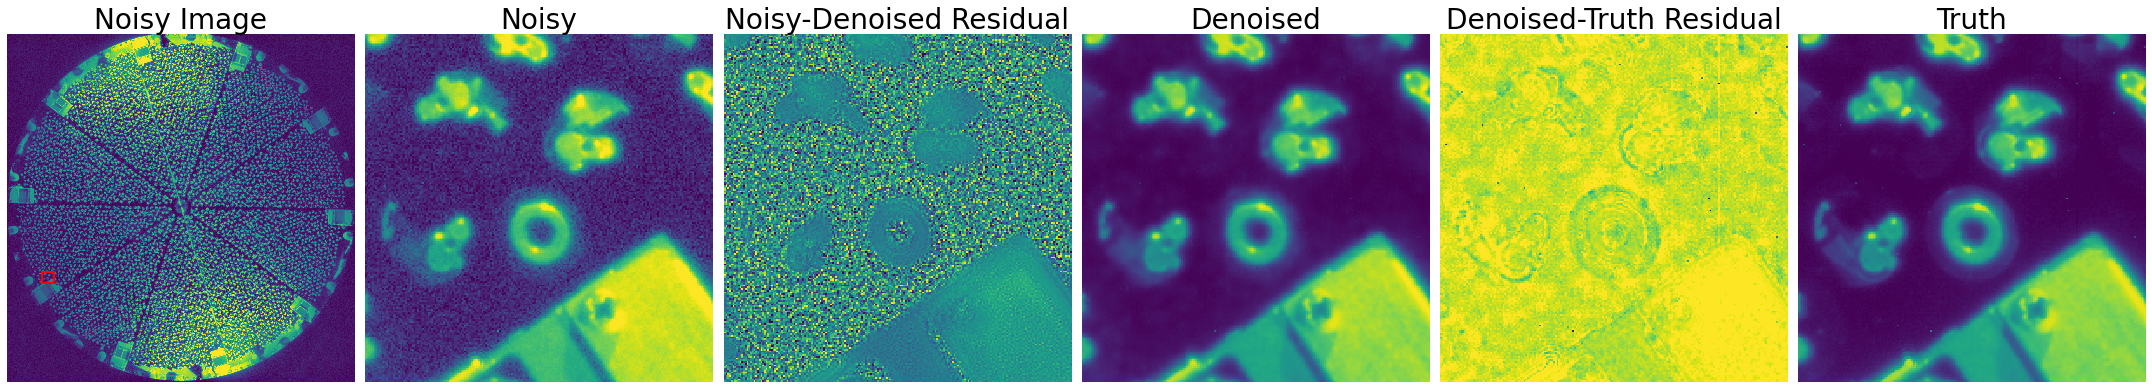

In [12]:
plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                x_start_idx=600,
                y_start_idx=4100)

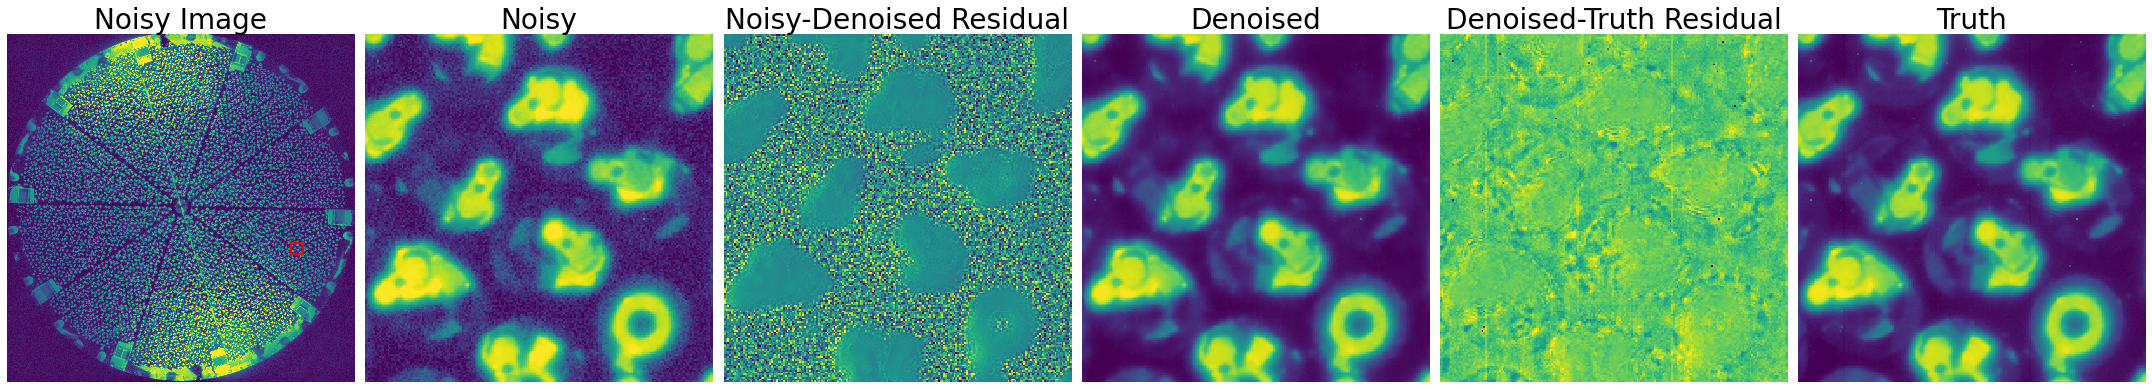

In [13]:
    
plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                x_start_idx=1200,
                y_start_idx=3100)

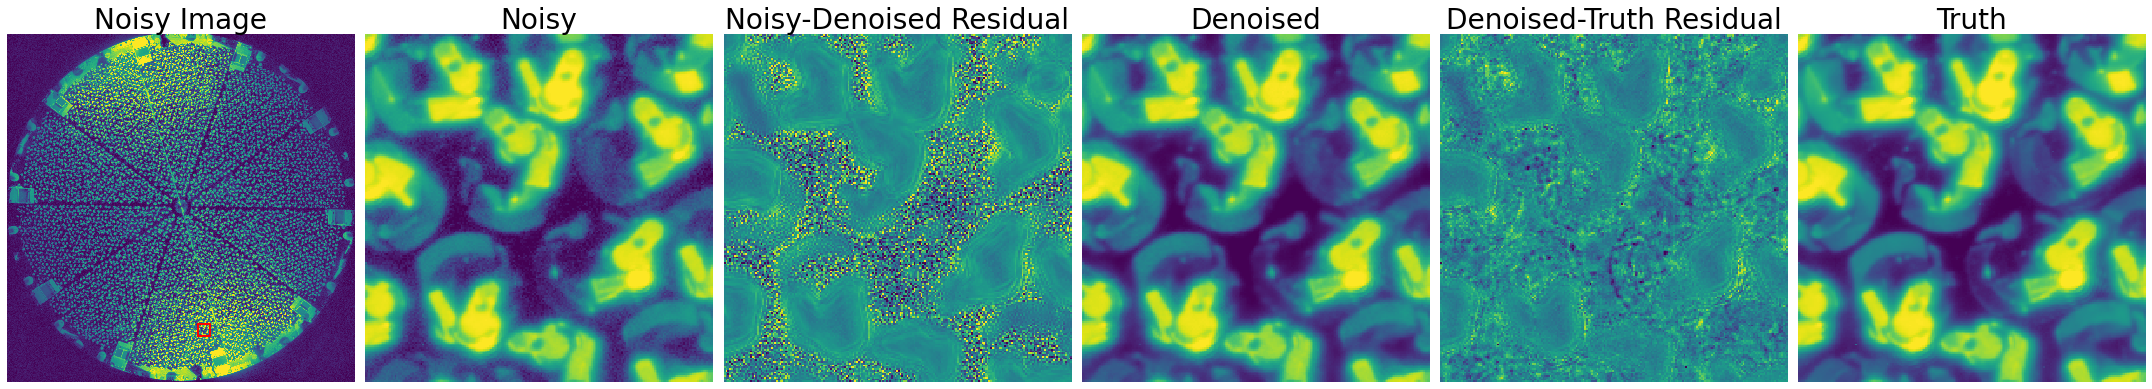

In [14]:
plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                x_start_idx=3300,
                y_start_idx=5000)

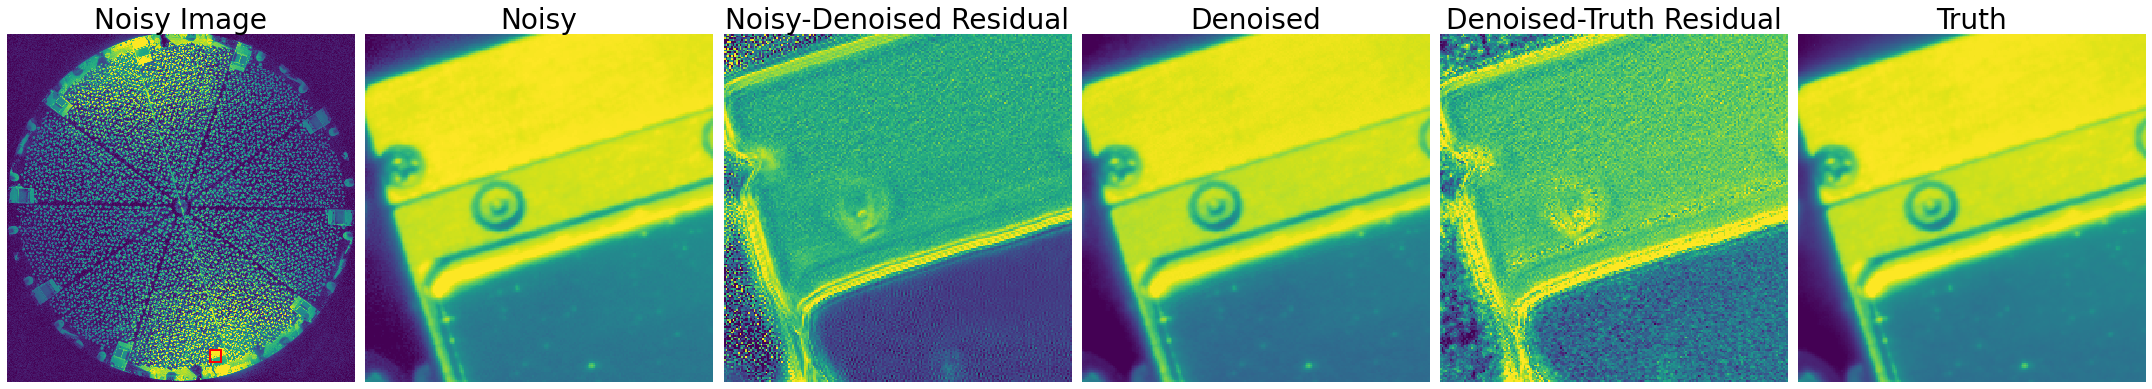

In [15]:
plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                x_start_idx=3500,
                y_start_idx=5450)

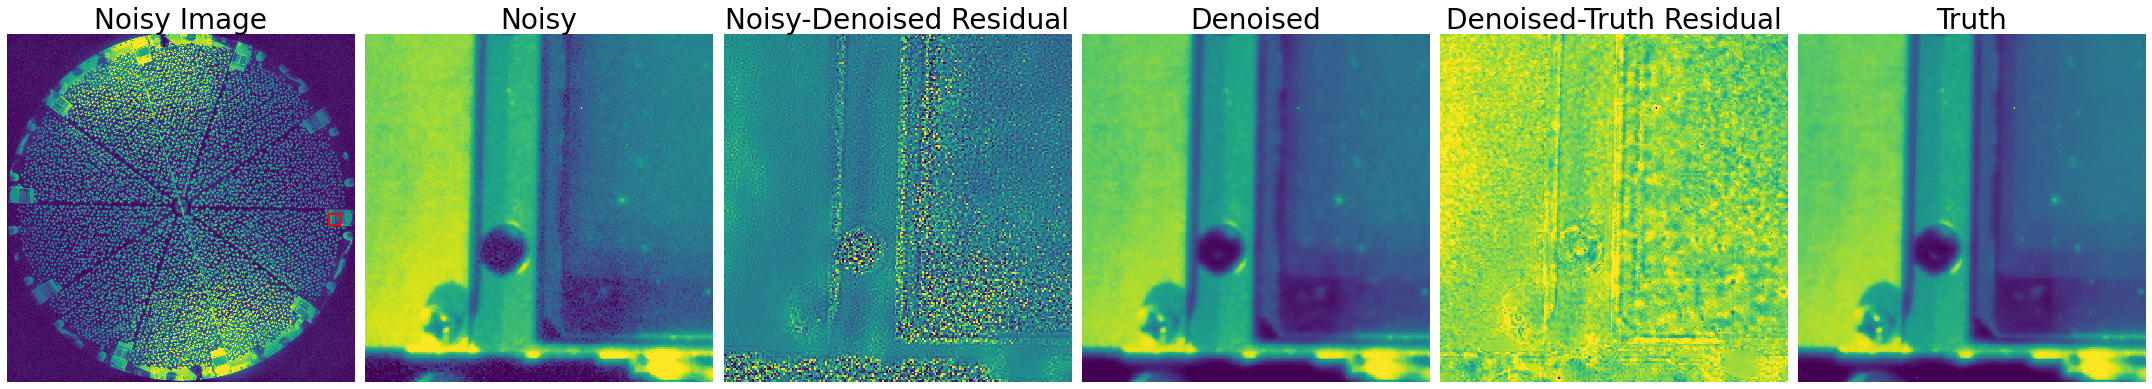

In [16]:
plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                x_start_idx=5550,
                y_start_idx=3100)

# Other plotting function that only has residual wrt noisy-denoised **NOT** denoised-truth

In [ ]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    x_start_idx,
                    y_start_idx):
    
    data_6k_raw = raw_data[0][0][0][y_start_idx:y_start_idx+size, x_start_idx:x_start_idx+size]
    data_6k_truth = raw_data[1][0][0][y_start_idx:y_start_idx+size, x_start_idx:x_start_idx+size]

    full_img_inf = inf_data[0][0][y_start_idx:y_start_idx+size, x_start_idx:x_start_idx+size]
        
    
    fig, ax = plt.subplots(1, 5,figsize=(30, 26))
    vmin, vmax = np.percentile(data_6k_raw, (1,99))
    vmin_full, vmax_full = np.percentile(raw_data[0][0][0], (1,99))

    ax[0].imshow(raw_data[0][0][0], vmin=vmin_full, vmax=vmax_full, origin='upper', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Image', fontsize=28) 
    rect = Rectangle((x_start_idx, y_start_idx), size, size, linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[1].imshow(data_6k_raw, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Noisy',fontsize=28) 
    ax[2].imshow(full_img_inf - data_6k_raw, origin='upper', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Noisy-Denoised Residual', fontsize=28)
    ax[3].imshow(full_img_inf, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Denoised',fontsize=28) 
    ax[4].imshow(data_6k_truth, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[4].axis('off')
    ax[4].set_title('Truth', fontsize=28)
    
    fig.tight_layout()
    
plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                x_start_idx=1200,
                y_start_idx=3100)